### ChatGPT prompt 1
```
Make Stan code for the following: 
--- 
y ~ Binomial(N, q) 

q = p_yes + (1-p_yes) * theta 

theta ~ Beta(alpha, beta)
```

In [2]:
stan_code = """
data {
  int<lower=0> N;                           // number of trials
  int<lower=0, upper=N> y;                  // number of "YES" responses
  real<lower=0, upper=1> p_yes;             // forced-YES probability (known)
  real<lower=0> alpha;                      // Beta prior hyperparameter
  real<lower=0> beta;                       // Beta prior hyperparameter
}

parameters {
  real<lower=0, upper=1> theta;             // true prevalence
}

transformed parameters {
  real<lower=0, upper=1> q;                 // effective YES probability
  q = p_yes + (1 - p_yes) * theta;
}

model {
  // Prior
  theta ~ beta(alpha, beta);

  // Likelihood
  y ~ binomial(N, q);
}

generated quantities {
  // Posterior predictive draw
  int y_rep = binomial_rng(N, q);

  // Optional: invert q to "recover" theta via the randomized-response formula.
  // This equals theta in this model, but it's handy for clarity/debugging.
  real<lower=0, upper=1> theta_via_q = (q - p_yes) / (1 - p_yes);
}
"""

### ChatGPT prompt 2

1. Make a python code to do Bayesian analysis using cmdstanpy. 

    N = 100, y=80, alpha = 1, beta = 1 2. 

2. Make explanation using the result of the computation. 

3. Draw plots to show the result of analysis.


# Bayesian Analysis of a Randomized-Response Model (CmdStanPy)

This notebook estimates the true prevalence `θ` under a **randomized-response** design:

- Observation model:  
  $$ y \sim \mathrm{Binomial}(N, q),\quad q = p_{\text{yes}} + (1 - p_{\text{yes}})\,\theta. $$
- Prior: \(\theta \sim \mathrm{Beta}(\alpha, \beta)\).

We use **Stan** (via `cmdstanpy`) to sample from the posterior and visualize results for:
- $N=100$, $y=80$, $ p_{\text{yes}}=0.5 $, $\alpha=\beta=1 $.



## Setup

If `cmdstanpy` or `arviz` is not installed, run the following in a terminal:

```bash
pip install cmdstanpy arviz matplotlib
python -c "from cmdstanpy import install_cmdstan; install_cmdstan()"
```


## Stan model

In [5]:

from pathlib import Path
stan_path = Path("randomized_response_2nd.stan")
#stan_path.write_text('\n// randomized_response.stan\ndata {\n  int<lower=0> N;                           // number of trials\n  int<lower=0, upper=N> y;                  // number of "YES" responses\n  real<lower=0, upper=1> p_yes;             // forced-YES probability (known)\n  real<lower=0> alpha;                      // Beta prior hyperparameter\n  real<lower=0> beta;                       // Beta prior hyperparameter\n}\n\nparameters {\n  real<lower=0, upper=1> theta;             // true prevalence\n}\n\ntransformed parameters {\n  real<lower=0, upper=1> q;                 // effective YES probability\n  q = p_yes + (1 - p_yes) * theta;\n}\n\nmodel {\n  // Prior\n  theta ~ beta(alpha, beta);\n\n  // Likelihood\n  y ~ binomial(N, q);\n}\n\ngenerated quantities {\n  // Posterior predictive draw\n  int y_rep = binomial_rng(N, q);\n\n  // Explicit inversion linkage (redundant but convenient for reporting)\n  real<lower=0, upper=1> theta_via_q = (q - p_yes) / (1 - p_yes);\n}\n')
stan_path.write_text(stan_code)
print(f"Wrote {stan_path.resolve()}")
stan_file = stan_path.resolve()


Wrote D:\Python\KOS6002\randomized_response_2nd.stan


## Fit with CmdStanPy

In [10]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data (your request)
N, y = 100, 80
alpha, beta = 1.0, 1.0
p_yes = 0.5

model = CmdStanModel(stan_file=stan_file)

fit = model.sample(
    data=dict(N=N, y=y, p_yes=p_yes, alpha=alpha, beta=beta),
    seed=2025,
    chains=4,
    parallel_chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    adapt_delta=0.95,
)

print(fit.diagnose())  # sampler diagnostics
draws = fit.draws_pd()
idata = az.from_cmdstanpy(posterior=fit)

az.summary(idata, var_names=["theta", "q"], round_to=4)


14:16:32 - cmdstanpy - INFO - No CmdStan installation found.
14:16:32 - cmdstanpy - INFO - Cannot determine whether version is before 2.27.
14:16:32 - cmdstanpy - INFO - No CmdStan installation found.
14:16:32 - cmdstanpy - INFO - Cannot determine whether version is before 2.36.


ValueError: CmdStan installataion missing binaries in C:\Users\Ko Kun-Wook\.cmdstan\cmdstan-2.37.0/bin. Re-install cmdstan by running command "install_cmdstan --overwrite", or Python code "import cmdstanpy; cmdstanpy.install_cmdstan(overwrite=True)"

## Plots

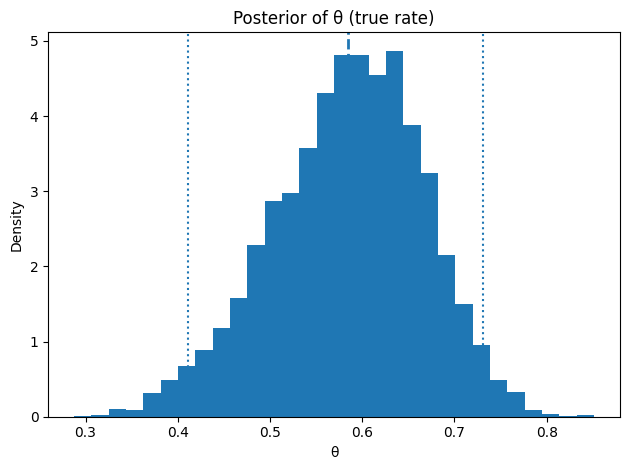

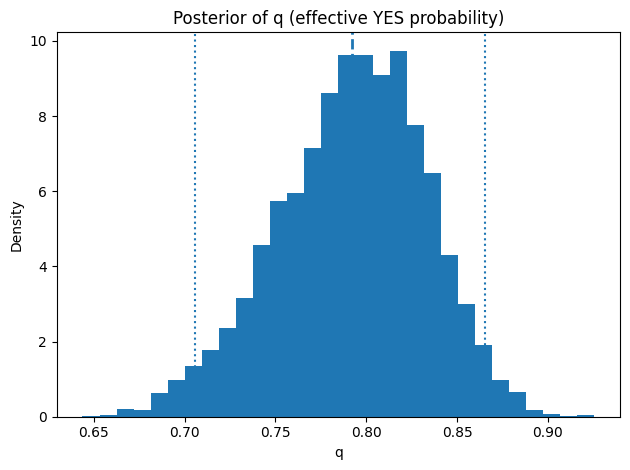

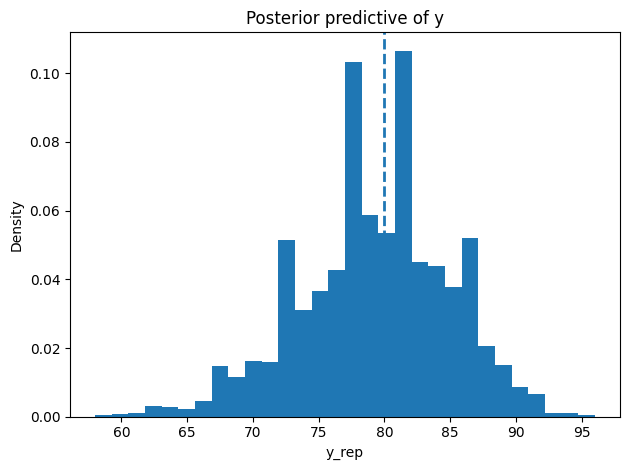

In [ ]:

theta = draws["theta"].to_numpy()
q = draws["q"].to_numpy()
y_rep = draws["y_rep"].to_numpy()

def hpd_interval(x, alpha=0.05):
    lo, hi = np.quantile(x, [alpha/2, 1 - alpha/2])
    return lo, hi

theta_mean = theta.mean()
theta_lo, theta_hi = hpd_interval(theta)
q_mean = q.mean()
q_lo, q_hi = hpd_interval(q)

# 1) Posterior of theta
plt.figure()
plt.hist(theta, bins=30, density=True)
plt.axvline(theta_mean, linestyle="--", linewidth=2)
plt.axvline(theta_lo, linestyle=":")
plt.axvline(theta_hi, linestyle=":")
plt.title("Posterior of θ (true rate)")
plt.xlabel("θ"); plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 2) Posterior of q
plt.figure()
plt.hist(q, bins=30, density=True)
plt.axvline(q_mean, linestyle="--", linewidth=2)
plt.axvline(q_lo, linestyle=":")
plt.axvline(q_hi, linestyle=":")
plt.title("Posterior of q (effective YES probability)")
plt.xlabel("q"); plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 3) Posterior predictive of y
plt.figure()
plt.hist(y_rep, bins=30, density=True)
plt.axvline(y, linestyle="--", linewidth=2, label="observed y")
plt.title("Posterior predictive of y")
plt.xlabel("y_rep"); plt.ylabel("Density")
plt.tight_layout()
plt.show()


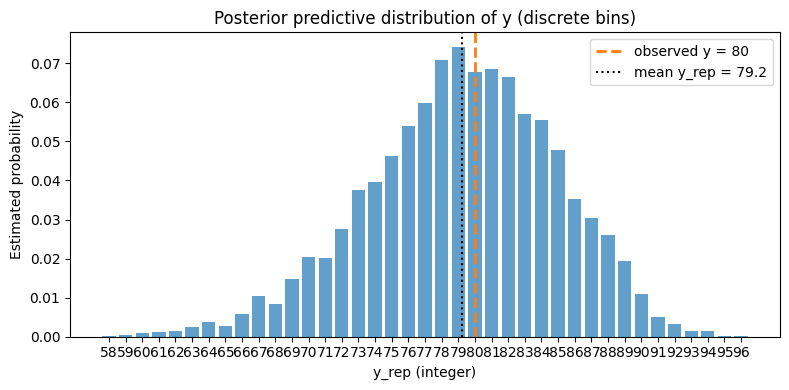

In [ ]:
# Discrete-aware histogram for posterior predictive y_rep (uses existing y_rep, y, np, plt)
vals = y_rep.astype(int)
minv, maxv = int(vals.min()), int(vals.max())
bins = np.arange(minv - 0.5, maxv + 1.5, 1)  # half-integer edges so each integer is a single bin

plt.figure(figsize=(8, 4))
plt.hist(vals, bins=bins, density=True, rwidth=0.8, color="C0", alpha=0.7)
plt.xticks(np.arange(minv, maxv + 1, 1))
plt.xlabel("y_rep (integer)")
plt.ylabel("Estimated probability")
plt.title("Posterior predictive distribution of y (discrete bins)")

# mark observed y and posterior predictive mean
plt.axvline(y, color="C1", linestyle="--", linewidth=2, label=f"observed y = {y}")
plt.axvline(vals.mean(), color="k", linestyle=":", linewidth=1.5, label=f"mean y_rep = {vals.mean():.1f}")

plt.legend()
plt.tight_layout()
plt.show()


## Interpretation

- The observed “YES” probability is \(q = p_{\text{yes}} + (1-p_{\text{yes}})\theta\).  
  With \(p_{\text{yes}}=0.5\), we have \(q = 0.5 + 0.5\,\theta\) and the de-biasing identity \( \theta = 2q - 1\).
- The posterior for \( \theta \) summarizes the **true** prevalence after accounting for forced-YES answers.
- The posterior predictive for \( y \) shows how replicated “YES” counts would look if we repeated the study.
- Report the posterior mean or median of \( \theta \) and a 95% credible interval as your main result.


## (Optional) Analytic cross-check

In [ ]:

# Cross-check: With a uniform prior on theta, q is uniform on [p_yes, 1].
# The posterior for q is proportional to q^y (1-q)^(N-y) truncated to [p_yes, 1].
# This is essentially a truncated Beta(y+1, N-y+1). Transform back via theta = (q - p_yes)/(1-p_yes).

from scipy.stats import beta as beta_dist
rng = np.random.default_rng(123)
a_post = y + 1
b_post = N - y + 1
q_draws = beta_dist(a_post, b_post).rvs(size=500000, random_state=rng)
q_draws = q_draws[q_draws >= p_yes]
theta_draws = (q_draws - p_yes) / (1 - p_yes)

def summarize(arr):
    return dict(mean=float(np.mean(arr)),
                median=float(np.median(arr)),
                sd=float(np.std(arr, ddof=1)),
                q025=float(np.quantile(arr, 0.025)),
                q975=float(np.quantile(arr, 0.975)))

print("Analytic θ summary (truncated-Beta route):", summarize(theta_draws))
print("Stan θ summary:", summarize(theta))


Analytic θ summary (truncated-Beta route): {'mean': 0.5881071598671292, 'median': 0.5921017456666554, 'sd': 0.07961056027396074, 'q025': 0.42191126290243697, 'q975': 0.7326093877268929}
Stan θ summary: {'mean': 0.584264696515, 'median': 0.58924471, 'sd': 0.08198733250112093, 'q025': 0.41150103475, 'q975': 0.7309536372500001}


## Save posterior samples as CSV

In [ ]:

samples_df = draws[["theta", "q", "y_rep"]].copy()
csv_path = "posterior_samples_cmdstan.csv"
samples_df.to_csv(csv_path, index=False)
print("Wrote", csv_path)


Wrote posterior_samples_cmdstan.csv
